In [143]:
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
import sys
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap, Team, DriverTeamSession, PitStop
from utils import correct_fuel_effect, extract_driver_strategies, get_base_sector_times, get_tyre_deg_per_driver, get_race_session, get_safety_car_penalty, get_driver_pit_time

import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from itertools import product

# Initialize database connection
global db_session
engine, db_session = init_db()

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) 


## 1) Query race into df and pre process

In [144]:

def get_race_df(year, circuit):
	race_session_db = get_race_session(year, circuit, db_session)

	base_sector_times = get_base_sector_times(year, circuit, db_session)

	laps = race_session_db.laps

	# Convert to DataFrame
	laps_data = []
	for lap in laps:
		# Add a row for Sector 1
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 1,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s1_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status,
			"base_sector_time": base_sector_times[lap.driver.driver_num][1]
		})

		# Add a row for Sector 2
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 2,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s2_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status,
			"base_sector_time": base_sector_times[lap.driver.driver_num][2]
		})

		# Add a row for Sector 3
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 3,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s3_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status,
			"base_sector_time": base_sector_times[lap.driver.driver_num][3]
		})

	# Create a DataFrame from the list of dictionaries
	df = pd.DataFrame(laps_data)
	

	df = df.sort_values(["lap_num", "sector", "position"]).reset_index(drop=True)

	return df

	
def add_race_data(df):
	# Calculate cumulative race time for each driver
	df["cumulative_time"] = df.groupby("driver_name")["sector_time"].cumsum()
 
	# Calculate rolling pace (average lap time over the last 5 laps)
	df["pace"] = (
		df.groupby(["driver_name", "sector"])["sector_time"]
		.rolling(window=5, min_periods=1)
		.mean()
		.reset_index(level=[0, 1], drop=True)
	)

	# Get car ahead"s cumulative time (car immediately ahead in position for each lap)
	df["front_cumulative_time"] = df.groupby(["lap_num", "sector"])["cumulative_time"].shift(1)
	# This gap is calculated only for drivers who are not in the lead position (position > 1)
	df["gap"] = df["cumulative_time"] - df["front_cumulative_time"]
	df["gap"] = df["gap"].fillna(0)  # Leader has no car ahead, so gap is 0

	# Calculate tyre difference (compared to car immediately ahead in THIS Sector)
	df["front_tyre"] = df.groupby(["lap_num", "sector"])["tyre_type"].shift(1)
	df["tyre_diff"] = df["front_tyre"] - df["tyre_type"]
	df["tyre_diff"] = df["tyre_diff"].fillna(0)  # Leader has no car ahead

	# Calculate tyre age difference (compared to car immediately ahead in THIS Sector)
	df["front_laps"] = df.groupby(["lap_num", "sector"])["stint_lap"].shift(1)
	df["stint_laps_diff"] = df["front_laps"] - df["stint_lap"]
	df["stint_laps_diff"] = df["stint_laps_diff"].fillna(0)  # Leader has no car ahead

	# Calculate DRS availability (within 1s of car ahead IN THIS Sector)
	df["drs_available"] = (
		(df["gap"] <= 1) &
		(df["position"] > 1) &
		(df["lap_num"] > 1)
	)


	# df["next_position"] = df.groupby("driver_name")["position"].shift(1) 
	# df["overtaken"] = ((df["next_position"] < df["position"]) | 
	# 				  (df["next_position"].isna()))


	# Shift the "position" and "pit" columns
	df["next_position"] = df.groupby("driver_name")["position"].shift(1)
	df["next_pit"] = df.groupby("driver_name")["pit"].shift(-1)

	# Handle NaN values in 'next_pit' by filling them with False
	df["next_pit"] = df["next_pit"].fillna(False)

	# Define the "overtaken" column
	df["overtaken"] = (
		((df["next_position"] < df["position"]) | (df["next_position"].isna()))  # Original condition
		& (~df["next_pit"])  # Ensure the driver in the next position is not pitting
	)

	# # Create target variable for overtaking model)
	# # Step 1: Detect position improvement on the next sector
	# df.loc[:, "next_position"] = df.groupby("driver_name")["position"].shift(-1)
	# df.loc[:, "position_improved"] = (
	# 	(df["next_position"] < df["position"]) |  # Position improved
	# 	(df["next_position"].isna())  # Handle NaN values
	# )

	# # Step 2: Identify the sector with the minimum gap for each driver and lap
	# df.loc[:, "min_gap_sector"] = df[df["position_improved"]].groupby(["driver_name", "lap_num"])["gap"].transform("idxmin")

	# # Step 3: Propagate the overtaken flag to the sector with the minimum gap
	# df.loc[:, "overtaken"] = False  # Initialize the overtake flag
	# for idx in df[df["position_improved"]].index:
	# 	driver = df.loc[idx, "driver_name"]
	# 	lap = df.loc[idx, "lap_num"]
		
	# 	# Find the sector with the minimum gap for this driver and lap
	# 	min_gap_idx = df.loc[
	# 		(df["driver_name"] == driver) & 
	# 		(df["lap_num"] == lap) & 
	# 		(df["position_improved"]), "min_gap_sector"
	# 	].iloc[0]
		
	# 	# Set the overtaken flag only for the sector with the minimum gap
	# 	if idx == min_gap_idx:
	# 		df.loc[idx, "overtaken"] = True

	# # Cleanup intermediate columns
	# df = df.drop(columns=["position_improved", "min_gap_sector"], errors="ignore")
	

	# Cleanup and final sorting
	df = df.drop(columns=["front_cumulative_time", "front_tyre", "next_position"])
	# df = df.sort_values(["lap_num", "sector", "position"]).reset_index(drop=True)

	try:
		new_order = [
			"lap_num", "sector", "base_sector_time", "stint_num", "stint_lap", "position", "driver_name",
			"driver_number", "sector_time", "gap", "cumulative_time", "tyre_type", "tyre_laps", 
			"pit", "drs_available", "overtaken", "tyre_diff", "front_laps", "stint_laps_diff", "track_status", "pace"
		]

		df = df[new_order]
	except:
		print("Extra column")
	return df

global year
global circuit
year = 2024
# circuit = "Melbourne"
# circuit = "Sakhir"
# circuit = "Monza"
# circuit = "Mexico City"
circuit = "Austin"
# circuit = "Yas Island"

race_session_db = get_race_session(year, circuit, db_session)

df = get_race_df(year, circuit)
df = add_race_data(df)


# df[["lap_num", "sector", "position", "driver_name", "gap", "overtaken"]]
# df[df["driver_number"]==14]
# df[df["track_status"]!=1]


/tmp/ipykernel_85203/1366663541.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["next_pit"] = df["next_pit"].fillna(False)


In [145]:
def setup_race_data(race_df, race_session_db):
	driver_strategies = extract_driver_strategies(race_df)
	
	# Extract tyre degradation curves
	driver_tyre_coefficients = get_tyre_deg_per_driver(race_df)
	
	# Precompute driver strategies

	# Correct fuel effects in the race data
	max_laps = race_df["lap_num"].max()
	race_df = correct_fuel_effect(race_df)

	drivers = race_df["driver_number"].unique()

	base_sector_times = get_base_sector_times(year, circuit, db_session)

	driver_names = {
		driver: race_df[race_df["driver_number"] == driver]["driver_name"].iloc[0]
		for driver in drivers
	}

	# Precompute fuel corrections
	max_fuel_kg = 110
	fuel_effect_per_kg = 0.03
	fuel_corrections = {
		lap: (max_fuel_kg - (lap - 1) * (max_fuel_kg / max_laps)) * fuel_effect_per_kg
		for lap in range(1, max_laps + 1)
	}


	# 
	session_results = (
		db_session.query(SessionResult.grid_pos, Driver.driver_num, SessionResult.end_status)
		.join(Session, Session.session_id == SessionResult.session_id)
		.join(Driver, Driver.driver_id == SessionResult.driver_id)
		.filter(SessionResult.session_id == race_session_db.session_id)
		.all()
	)
	# Convert session results to a dictionary
	starting_positions = {driver_num: grid_pos for grid_pos, driver_num, _ in session_results}

	# Initialize an empty dictionary to store retirements by lap
	retirements_by_lap = {}

	# Iterate through session results to determine retirements
	for driver_id, driver_num, end_status in session_results:
		# Check if the driver retired (end_status is not "Finished" or "+1 Lap")
		if end_status and not (end_status.startswith("Finished") or end_status.startswith("+")):
			# Find the maximum lap number for the driver (last recorded lap)
			lap_retired = df[df["driver_number"] == driver_num]["lap_num"].max()
			
			# Add the driver to the list of retirees for the corresponding lap
			if lap_retired not in retirements_by_lap:
				retirements_by_lap[lap_retired] = []
			retirements_by_lap[lap_retired].append(driver_num)

	# Get initial positions (starting grid positions) for each driver

	df["starting_position"] = None  # Initialize column with None
	for driver_num, grid_pos in starting_positions.items():
		# Find the first occurrence of the driver
		first_row_index = df[df["driver_number"] == driver_num].index[0]
		df.at[first_row_index, "starting_position"] = grid_pos
	
	# Get safety car laps
	safety_car_laps = race_df[(race_df["track_status"] != 1) & (race_df["position"]==1)]
	
	# Group by lap_num and convert each group to a list of dictionaries
	saftey_car_laps = []
	for lap_num, group in safety_car_laps.groupby("lap_num"):
		saftey_car_laps.append(lap_num)
	
	# get how much slower safety car laps are on this track
	penalty_percentage = get_safety_car_penalty(year, circuit, db_session)

	# get pit stop times
	driver_pit_times = get_driver_pit_time(year, circuit, db_session)
	return {
		"driver_tyre_coefficients": driver_tyre_coefficients,
		"driver_strategies": driver_strategies,
		"race_df": race_df,
		"max_laps": max_laps,
		"drivers": drivers,
		"driver_names": driver_names,
		"initial_positions": starting_positions,
		"base_sector_times": base_sector_times,
		"fuel_corrections": fuel_corrections,
		"saftey_car_laps": saftey_car_laps,
		"retirement_laps": retirements_by_lap,
		"safety_car_penalty_percentage": penalty_percentage,
		"driver_pit_times": driver_pit_times
	}

### Now create overtaking model

/tmp/ipykernel_85203/1366663541.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["next_pit"] = df["next_pit"].fillna(False)
/tmp/ipykernel_85203/1366663541.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["next_pit"] = df["next_pit"].fillna(False)


Correlation with Target Variable:
sector             0.175073
pace               0.115304
sector_time        0.114380
stint_laps_diff    0.091966
gap                0.091910
drs_available      0.056430
pit                0.029920
tyre_diff          0.022552
cumulative_time    0.001666
Name: overtaken, dtype: float64


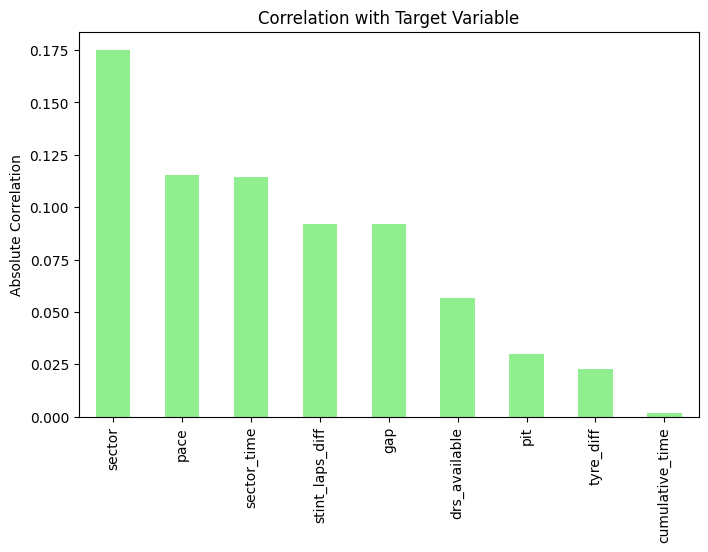

In [146]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE


years = [2022, 2023]

df_training = pd.DataFrame()
for training_year in years:	
	# Get race DataFrame
	df_overtake_training = get_race_df(training_year, circuit)

	# Add additional race data
	df_overtake_training = add_race_data(df_overtake_training)

	# Append to the combined training DataFrame
	df_training = pd.concat([df_training, df_overtake_training], ignore_index=True)
        
# Define features and target
features = [
	"gap",
	'sector',
	"tyre_diff",
	"stint_laps_diff",
	"drs_available",
	"cumulative_time",
	"sector_time",
	"pace",
	"pit"
]

X = df_training[features]
y = df_training["overtaken"]


# Train the model on the resampled data

# Handle missing values
X = X.fillna(X.mean())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


# Base model
gbc = GradientBoostingClassifier(
	n_estimators=200,
	learning_rate=0.05,
	max_depth=3,
	subsample=0.8,
	random_state=42
)



# Calibrate for better probabilities
model = CalibratedClassifierCV(gbc, method="sigmoid", cv=3)

# Train on all data
model.fit(X_resampled, y_resampled)


feature_means = X.mean()

def predict_overtake(new_race_df):
	# Select the same features used during training
	X_new = new_race_df[features]
	
	# Handle missing values (if any)
	X_new = X_new.fillna(feature_means)
	
	# Make predictions using the trained model
	new_race_df["predicted_overtake"] = model.predict(X_new)
	
	return new_race_df


import matplotlib.pyplot as plt

# Calculate correlation with the target variable
correlation_with_target = df_training[features + ["overtaken"]].corr()["overtaken"].drop("overtaken")

# Sort by absolute correlation
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

# Display the results
print("Correlation with Target Variable:")
print(correlation_with_target)

# Plot correlations
plt.figure(figsize=(8, 5))
correlation_with_target.plot(kind="bar", color='lightgreen')
plt.title("Correlation with Target Variable")
plt.ylabel("Absolute Correlation")
plt.show()

In [147]:
from sklearn.metrics import accuracy_score, classification_report


# Predict overtakes using the rule-based function
new_race_df = predict_overtake(df)

# Calculate accuracy
actual_overtakes = new_race_df["overtaken"]
predicted_overtakes = new_race_df["predicted_overtake"]
accuracy = accuracy_score(actual_overtakes, predicted_overtakes)
print(f"Accuracy: {accuracy:.3f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(
	actual_overtakes,
	predicted_overtakes,
	target_names=["No Overtake", "Overtaken"]
))

Accuracy: 0.985

Classification Report:
              precision    recall  f1-score   support

 No Overtake       0.99      0.99      0.99      3127
   Overtaken       0.52      0.56      0.54        50

    accuracy                           0.98      3177
   macro avg       0.76      0.78      0.77      3177
weighted avg       0.99      0.98      0.99      3177



precision    recall  f1-score   support

 No Overtake       0.99      0.99      0.99      3105
   Overtaken       0.52      0.67      0.58        72

    accuracy                           0.98      3177
   macro avg       0.75      0.83      0.79      3177
weighted avg       0.98      0.98      0.98      3177

In [148]:
race_data = setup_race_data(df, race_session_db)

In [149]:
from collections import deque

def race_sim(precomputed_data, given_driver=None, simulated_strategy=None):
	"""
	simulated_strategy
	"""
	# Extract precomputed data
	driver_tyre_coefficients = precomputed_data["driver_tyre_coefficients"]
	driver_strategies = precomputed_data["driver_strategies"]
	max_laps = precomputed_data["max_laps"]
	drivers = precomputed_data["drivers"]
	driver_names = precomputed_data["driver_names"]
	initial_positions = precomputed_data["initial_positions"]
	base_sector_times = precomputed_data["base_sector_times"]
	fuel_corrections = precomputed_data["fuel_corrections"]
	saftey_car_laps = precomputed_data["saftey_car_laps"]
	retirement_laps = precomputed_data["retirement_laps"]
	safety_car_penalty_percentage = precomputed_data["safety_car_penalty_percentage"]
	driver_pit_times = precomputed_data["driver_pit_times"]

	drivers_data = []

	if given_driver and simulated_strategy:
		driver_strategies[given_driver] = simulated_strategy

	for driver in drivers:
		drivers_data.append({
			"driver_number": driver,
			"driver_name": driver_names[driver],
			"pit_schedule": {key: value for key, value in driver_strategies[driver].items() if key != 1},
			"tyre_type": driver_strategies[driver][1],
			"lap_num": 1,
			"sector": 0,
			"sector_time": 0.0,
			"stint_lap": 1,
			"cumulative_time": 0.0,
			"gap": 0.0,
			"pit": False,
			"pace": 0,
			"position": initial_positions[driver],
			"starting_pos": initial_positions[driver],
			"base_sector_times": base_sector_times[driver],
			"tyre_diff": 0,  # Initialize tyre difference as 0
			"stint_laps_diff": 0,  # Initialize stint laps difference as 0
			"drs_available": False,  # Initialize DRS availability as False
			"retired": False,
		})
		
	drivers_df = pd.DataFrame(drivers_data)
	
	# {driver: {sector: {last_5: []}}}

	driver_pace_per_sec = {
		driver: {sector: deque(maxlen=5) for sector in range(1, 4)}  # Sectors 1, 2, 3
		for driver in drivers
	}
	
	# driver_pace_per_sec = {} # {driver: {sector: {last_5: []}}}

	simulated_data = []
	num_overtakes = 0
	for lap in range(1, max_laps + 1):
		# if lap == 55:
		# 	break
		drivers_df["lap_num"] += 1
		drivers_df["stint_lap"] += 1

		if lap in saftey_car_laps:
			saftey_car = True
		else:
			saftey_car = False

		if lap in retirement_laps:
			retiring_drivers = retirement_laps[lap]
			
			# Move all drivers behind the retiring drivers up by 1 position
			for driver in retiring_drivers:
				retiring_position = drivers_df.loc[drivers_df["driver_number"] == driver, "position"].values[0]
				drivers_df.loc[drivers_df["position"] > retiring_position, "position"] -= 1

			# Sort the DataFrame by position to ensure correct ordering
			drivers_df = drivers_df.sort_values(by="position", ascending=True)
			
			# Mark retiring drivers as retired and adjust their position to 999
			drivers_df.loc[drivers_df["driver_number"].isin(retiring_drivers), "retired"] = True
			drivers_df.loc[drivers_df["driver_number"].isin(retiring_drivers), "position"] = 999
	

		for sector in range(1, 4):
			drivers_df["sector"] = sector
			
			for index, row in drivers_df.iterrows():
				if row["retired"]:
					continue
	
				a, b, c = driver_tyre_coefficients[row["driver_number"]][row["tyre_type"]][sector]
				sector_time = (
					row["base_sector_times"][sector]  # Base sector time for specific driver
					+ (a * drivers_df.at[index, "stint_lap"]**2 + b * drivers_df.at[index, "stint_lap"] + c)  # Tyre degradation
					+ fuel_corrections[lap]  # Fuel effect
				)

				# Update sector time and cumulative time
				drivers_df.at[index, "sector_time"] = sector_time
				if saftey_car:
					sector_time *= safety_car_penalty_percentage
					
				drivers_df.at[index, "cumulative_time"] += sector_time

				# add to find rolling average/pace later
				driver_pace_per_sec[row["driver_number"]][sector].append(sector_time)

				# Handle pit stops at the start of a lap (sector 1)
				if sector == 1 and lap in row["pit_schedule"]:
					drivers_df.at[index, "pit"] = True  # Mark pit stop
					drivers_df.at[index, "cumulative_time"] += driver_pit_times[row["driver_number"]]  # Add pit stop penalty
					drivers_df.at[index, "stint_lap"] = 1  # Reset stint lap
					drivers_df.at[index, "tyre_type"] = row["pit_schedule"][lap]  # Change tyre


				else:
					drivers_df.at[index, "pit"] = False
			
			# re-sort
			drivers_df = drivers_df[~drivers_df["retired"]].sort_values(by="cumulative_time", ascending=True)
			drivers_df["position"] = range(1, len(drivers_df) + 1)

			# Handle overtakes
			if saftey_car:
				continue
			for index, row in drivers_df.iterrows():
				if row["retired"]:
					continue
			
				ahead_pos = row["position"] - 1

				if ahead_pos > 0:
					ahead_index = drivers_df[drivers_df["position"] == ahead_pos].index[0]

					ahead_pos_time = drivers_df.at[ahead_index, "cumulative_time"]
				
					current_pos_time = row["cumulative_time"]
					if ahead_pos_time > current_pos_time:
						new_time = current_pos_time - 0.4
						drivers_df.at[ahead_index, "cumulative_time"] = new_time

						ahead_pos_time = new_time
						
					gap = current_pos_time - ahead_pos_time


					drivers_df.at[index, "gap"] = gap

					
				else:

					gap = 0
					drivers_df.at[index, "gap"] = 0

					

				if gap < 1 and ahead_pos > 0:
					# calculate pace
					sector_times = driver_pace_per_sec[row["driver_number"]][sector]
					if len(sector_times) > 0:
						rolling_pace = sum(sector_times) / len(sector_times)
					else:
						rolling_pace = 0.0  # Default value if no sector times are available yet

					drivers_df.at[index, "pace"] = rolling_pace

					# if ahead_pos > 0:
					ahead_row = drivers_df.loc[drivers_df["position"] == ahead_pos].iloc[0]
					
					# Tyre difference
					drivers_df.at[index, "tyre_diff"] = ahead_row["tyre_type"] - row["tyre_type"]

					# Stint laps difference
					drivers_df.at[index, "stint_laps_diff"] = ahead_row["stint_lap"] - row["stint_lap"]

					# DRS availability
					drivers_df.at[index, "drs_available"] = True

					
					drivers_df = predict_overtake(drivers_df)

					ahead_index = drivers_df[drivers_df["position"] == ahead_pos].index[0]
					# Check if an overtake is predicted
					if drivers_df.at[index, "predicted_overtake"]:
						num_overtakes += 1

						# Swap positions
						drivers_df.at[index, "position"], drivers_df.at[ahead_index, "position"] = drivers_df.at[ahead_index, "position"], drivers_df.at[index, "position"],

						drivers_df.at[index, "cumulative_time"], drivers_df.at[ahead_index, "cumulative_time"] = drivers_df.at[ahead_index, "cumulative_time"], drivers_df.at[index, "cumulative_time"]
						

	
	drivers_df.drop(columns=["base_sector_times"], inplace=True)
	print(f"Number of overtakes: {num_overtakes}")
	return drivers_df

sim_df = race_sim(race_data)
sim_df = sim_df.sort_values(by="position", ascending=True)

# Reset the index
sim_df = sim_df.reset_index(drop=True)
sim_df

# import cProfile
# import pstats

# # Wrap the race simulation in cProfile
# def profile_race_sim(precomputed_data):
#     # Create a profiler instance
#     profiler = cProfile.Profile()
    
#     # Start profiling
#     profiler.enable()
    
#     # Run the race simulation
#     sim_df = race_sim(precomputed_data)
    
#     # Stop profiling
#     profiler.disable()
    
#     # Save profiling results to a file
#     with open("race_sim_profile.txt", "w") as f:
#         stats = pstats.Stats(profiler, stream=f)
#         stats.sort_stats("cumulative")  # Sort by cumulative time
#         stats.print_stats()
    
#     print("Profiling complete. Results saved to 'race_sim_profile.txt'.")
#     return sim_df

# # Example usage
# sim_df = profile_race_sim(race_data)

# # Optional: Display the resulting DataFrame
# sim_df = sim_df.sort_values(by="position", ascending=True).reset_index(drop=True)
# print(sim_df)

/tmp/ipykernel_85203/316301474.py:170: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33.997994218208945' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  drivers_df.at[index, "pace"] = rolling_pace


Number of overtakes: 161


,driver_number,driver_name,pit_schedule,tyre_type,lap_num,sector,sector_time,stint_lap,cumulative_time,gap,pit,pace,position,starting_pos,tyre_diff,stint_laps_diff,drs_available,retired,predicted_overtake
0,16,Charles Leclerc,{27: 3},3,57,3,32.495089,30,5979.604031,0.000000,False,26.807070,1,4,0,-7,True,False,False
1,55,Carlos Sainz,{22: 3},3,57,3,32.539884,35,5981.191856,1.587825,False,26.860382,2,3,0,-12,True,False,True
2,23,Alexander Albon,"{4: 2, 34: 3}",3,57,3,33.183583,23,5994.156587,12.964731,False,38.471880,3,14,0,4,True,False,False
3,4,Lando Norris,{32: 3},3,57,3,32.669537,25,5998.884057,4.727470,False,40.206962,4,1,0,6,True,False,False
4,1,Max Verstappen,{26: 3},3,57,3,32.743283,31,5998.996287,0.112230,False,32.789658,5,2,0,-6,True,False,False
5,81,Oscar Piastri,{33: 3},3,57,3,32.739445,24,6006.694490,7.698203,False,27.779839,6,5,1,-22,True,False,True
6,11,Sergio Perez,{27: 3},3,57,3,32.962344,30,6057.815379,51.120889,False,40.900169,7,9,0,9,True,False,False
7,45,Franco Colapinto,{40: 2},2,57,3,32.491815,17,6058.290050,0.474671,False,32.589416,8,15,1,13,True,False,False
8,27,Nico Hulkenberg,{28: 3},3,57,3,32.745237,29,6064.562019,6.271969,False,32.906182,9,11,-1,-12,True,False,False
9,40,Liam Lawson,{37: 2},2,57,3,32.761808,20,6066.394844,1.832825,False,27.129841,10,19,1,18,True,False,False


In [150]:
import pandas as pd
import numpy as np

def compare_simulation_with_actual(sim_df, race_df):
	# Initialize a list to store comparison results
	comparison_results = []
	
	# Get unique drivers from the simulated DataFrame
	drivers = sim_df["driver_number"].unique()
	
	# Calculate cumulative times for each driver in both simulated and actual data
	for driver in drivers:
		# Simulated cumulative time for the driver
		sim_cumulative_time = sim_df[sim_df["driver_number"] == driver]["cumulative_time"].max()
		
		# Actual cumulative time for the driver
		actual_cumulative_time = race_df[race_df["driver_number"] == driver]["sector_time"].sum()

		# if actual_cumulative_time < 5000:
		# 	continue
		# Calculate the absolute error for the driver
		absolute_error = abs(sim_cumulative_time - actual_cumulative_time)
		
		# Store the results for the driver
		comparison_results.append({
			"driver_number": driver,
			"simulated_cumulative_time": sim_cumulative_time,
			"actual_cumulative_time": actual_cumulative_time,
			"absolute_error": absolute_error
		})
	
	# Convert the results to a DataFrame
	comparison_df = pd.DataFrame(comparison_results)
	
	# Calculate the total Mean Absolute Error (MAE)
	total_mae = comparison_df["absolute_error"].mean()
	
	return comparison_df, total_mae


# Example usage
# Assuming `sim_df` is the output of your simulation and `df` is the actual race DataFrame
comparison_df, total_mae = compare_simulation_with_actual(sim_df, df)



# Print the total MAE
print("\Mean Absolute Error (MAE):", total_mae)
comparison_df

\Mean Absolute Error (MAE): 341.9627832362732


,driver_number,simulated_cumulative_time,actual_cumulative_time,absolute_error
0,16,5979.604031,5681.959,297.645031
1,55,5981.191856,5689.567,291.624856
2,23,5994.156587,5693.767,300.389587
3,4,5998.884057,5695.994,302.890057
4,1,5998.996287,5700.980,298.016287
5,81,6006.694490,5702.098,304.596490
6,11,6057.815379,5738.383,319.432379
7,45,6058.290050,5749.716,308.574050
8,27,6064.562019,5741.533,323.029019
9,40,6066.394844,5747.729,318.665844


In [151]:
def get_accuracy(year, circuit, sim_df):
	# Fetch the actual race session from the database
	race_session = (
		db_session.query(Session)
		.join(RacingWeekend, Session.weekend_id == RacingWeekend.racing_weekend_id)
		.join(Circuit, RacingWeekend.circuit_id == Circuit.circuit_id)
		.filter(
			RacingWeekend.year == year,
			Circuit.circuit_name == circuit,
			Session.session_type == "Race"
		)
		.first()
	)

	if not race_session:
		raise ValueError(f"No race session found for {year} at {circuit}")

	# Fetch the actual race laps and results
	laps = race_session.laps
	session_results = (
		db_session.query(SessionResult.position, Driver.driver_num)
		.join(Session, Session.session_id == SessionResult.session_id)
		.join(Driver, Driver.driver_id == SessionResult.driver_id)
		.filter(SessionResult.session_id == race_session.session_id)
		.all()
	)

	# Convert session_results to a dictionary for easy lookup
	actual_results = {driver_num: position for position, driver_num in session_results}

	# Extract simulated results from sim_df
	sim_df = sim_df[~sim_df["retired"]]
	sim_results = sim_df.groupby("driver_number").last()["position"].to_dict()

	# Ensure both results have the same drivers
	common_drivers = set(actual_results.keys()).intersection(sim_results.keys())
	if not common_drivers:
		raise ValueError("No common drivers found between actual and simulated results")

	# Filter results to only include common drivers
	actual_positions = [actual_results[driver] for driver in common_drivers]
	sim_positions = [sim_results[driver] for driver in common_drivers]

	# Calculate accuracy metrics
	position_accuracy = sum(1 for a, s in zip(actual_positions, sim_positions) if a == s) / len(common_drivers)
	top_3_accuracy = sum(1 for a, s in zip(actual_positions, sim_positions) if (a <= 3 and s <= 3)) / 3
	mean_error = sum(abs(a - s) for a, s in zip(actual_positions, sim_positions)) / len(common_drivers)
	total_error = sum(abs(a - s) for a, s in zip(actual_positions, sim_positions))

	# Return accuracy metrics
	return {
		"position_accuracy": position_accuracy,
		"top_3_accuracy": top_3_accuracy,
		"mean_error": mean_error,
		"total_error": total_error,
	}

get_accuracy(year, circuit, sim_df)

{'position_accuracy': 0.2631578947368421,
 'top_3_accuracy': 0.6666666666666666,
 'mean_error': 1.894736842105263,
 'total_error': 36}

In [152]:
from skopt import gp_minimize
from skopt.space import Integer, Categorical

def optimize_strategy_up_to_3_stops(precomputed_data, driver_number=14, n_calls=100):

	max_laps = precomputed_data["max_laps"]

	# Define the search space
	space = [
		Categorical([1, 2, 3], name='start_tyre'),       # Starting tyre (1=Hard, 2=Medium, 3=Soft)
		Integer(2, max_laps - 1, name='pit1_lap'),      # First pit stop lap (optional)
		Categorical([1, 2, 3], name='pit1_tyre'),        # First pit stop tyre (optional)
		Integer(2, max_laps - 1, name='pit2_lap'),      # Second pit stop lap (optional)
		Categorical([1, 2, 3], name='pit2_tyre'),        # Second pit stop tyre (optional)
		Integer(2, max_laps - 1, name='pit3_lap'),      # Third pit stop lap (optional)
		Categorical([1, 2, 3], name='pit3_tyre'),        # Third pit stop tyre (optional)
	]

	def objective(params):
		start_tyre, pit1_lap, pit1_tyre, pit2_lap, pit2_tyre, pit3_lap, pit3_tyre = params

		# Construct the strategy dictionary
		strategy = {1: start_tyre}  # Always include the starting tyre

		# Add pit stops only if their laps are valid and in ascending order
		pit_laps = sorted(set([pit1_lap, pit2_lap, pit3_lap]))
		tyres = [pit1_tyre, pit2_tyre, pit3_tyre]

		# Ensure pit laps are within bounds and in ascending order
		valid_pit_laps = []
		valid_tyres = []
		for lap, tyre in zip(pit_laps, tyres):
			if 2 <= lap < max_laps:  # Only include valid pit laps
				valid_pit_laps.append(lap)
				valid_tyres.append(tyre)

		# Add valid pit stops to the strategy
		for lap, tyre in zip(valid_pit_laps, valid_tyres):
			strategy[lap] = tyre

		# Penalize strategies with fewer than 2 distinct tyre types
		tyre_types_used = set(strategy.values())
		if len(tyre_types_used) < 2:
			return 20.0  # Penalize with worst position

		# Run the simulation
		try:
			drivers_df = race_sim(precomputed_data, given_driver=driver_number, simulated_strategy=strategy)
			final_position = drivers_df[drivers_df['driver_number'] == driver_number]['position'].iloc[-1]
			return final_position  # Minimize finishing position
		except Exception as e:
			print(f"Error during simulation: {e}")
			return 20.0  # Return worst position in case of errors

	# Perform Bayesian optimization
	result = gp_minimize(
		objective,
		space,
		n_calls=n_calls,
		random_state=42,
		verbose=True
	)

	# Extract best parameters and construct the optimal strategy
	best_params = result.x
	best_strategy = {1: best_params[0]}  # Always include the starting tyre

	# Add valid pit stops to the strategy
	pit_laps = sorted(set([best_params[1], best_params[3], best_params[5]]))
	tyres = [best_params[2], best_params[4], best_params[6]]

	for lap, tyre in zip(pit_laps, tyres):
		if 2 <= lap < precomputed_data["max_laps"]:
			best_strategy[lap] = tyre

	best_position = result.fun

	print(f"Best Strategy: {best_strategy}")
	print(f"Best Finishing Position: {best_position}")

	return best_strategy, best_position

# Example usage
# best_strategy, best_position = optimize_strategy_up_to_3_stops(race_data, driver_number=10, n_calls=100)
# print(f"Best Strategy: {best_strategy}")
# print(f"Best Finishing Position: {best_position}")

In [153]:
from bayes_opt import BayesianOptimization
import numpy as np

def bayesian_strategy_optimization(race_data, given_driver, max_iterations=50):
	"""
	Optimize the pit strategy for a given driver using Bayesian Optimization.
	
	Args:
		race_data (dict): Precomputed race data.
		given_driver (int): The driver number to optimize the strategy for.
		max_iterations (int): Maximum number of iterations for optimization.
		
	Returns:
		tuple: Best strategy (dict) and best finishing position (int).
	"""
	# Extract precomputed data
	max_laps = race_data["max_laps"]
	initial_strategy = race_data["driver_strategies"][given_driver]  # Use the driver's actual race strategy

	# Define the objective function for Bayesian Optimization
	def objective_function(starting_tyre, pit1_lap, pit1_tyre, pit2_lap, pit2_tyre, pit3_lap, pit3_tyre):
		# Ensure pit laps are unique and within valid range
		pit_laps = sorted(set([int(pit1_lap), int(pit2_lap), int(pit3_lap)]))
		tyres = [int(pit1_tyre), int(pit2_tyre), int(pit3_tyre)]
		
		# Filter out invalid pit laps (e.g., out of bounds or overlapping)
		valid_pit_laps = []
		valid_tyres = []
		for lap, tyre in zip(pit_laps, tyres):
			if 2 <= lap < max_laps:  # Only include valid pit laps
				valid_pit_laps.append(lap)
				valid_tyres.append(tyre)

		# Construct the strategy dictionary
		strategy = {1: int(starting_tyre)}  # Starting tyre
		for lap, tyre in zip(valid_pit_laps, valid_tyres):
			strategy[lap] = tyre

		# Penalize strategies with fewer than 2 distinct tyre types
		tyre_types_used = set(strategy.values())
		if len(tyre_types_used) < 2:
			return -20.0  # Penalize with worst position (negative because we're maximizing)

		# Evaluate the strategy using the race simulation
		try:
			sim_df = race_sim(race_data, given_driver=given_driver, simulated_strategy=strategy)
			final_position = sim_df[sim_df["driver_number"] == given_driver]["position"].iloc[-1]
			return -final_position  # Negative because BayesianOptimization maximizes by default
		except Exception as e:
			print(f"Error during simulation: {e}")
			return -20.0  # Return worst position in case of errors

	# Set up the parameter bounds for Bayesian Optimization
	pbounds = {
		"starting_tyre": (1, 3),  # Starting tyre (1=Hard, 2=Medium, 3=Soft)
		"pit1_lap": (2, max_laps - 1),  # First pit stop lap (optional)
		"pit1_tyre": (1, 3),  # First pit stop tyre (optional)
		"pit2_lap": (2, max_laps - 1),  # Second pit stop lap (optional)
		"pit2_tyre": (1, 3),  # Second pit stop tyre (optional)
		"pit3_lap": (2, max_laps - 1),  # Third pit stop lap (optional)
		"pit3_tyre": (1, 3),  # Third pit stop tyre (optional)
	}

	# Initialize the Bayesian Optimizer
	optimizer = BayesianOptimization(
		f=objective_function,
		pbounds=pbounds,
		verbose=2,
		random_state=42
	)

	# Perform the optimization
	optimizer.maximize(init_points=5, n_iter=max_iterations)

	# Extract the best strategy from the optimizer
	best_params = optimizer.max["params"]
	best_starting_tyre = int(best_params["starting_tyre"])
	pit_laps = sorted(set([int(best_params["pit1_lap"]), int(best_params["pit2_lap"]), int(best_params["pit3_lap"])]))
	tyres = [int(best_params["pit1_tyre"]), int(best_params["pit2_tyre"]), int(best_params["pit3_tyre"])]

	# Construct the best strategy dictionary
	best_strategy = {1: best_starting_tyre}
	for lap, tyre in zip(pit_laps, tyres):
		if 2 <= lap < max_laps:  # Only include valid pit laps
			best_strategy[lap] = tyre

	# Evaluate the best strategy to get the finishing position
	sim_df = race_sim(race_data, given_driver=given_driver, simulated_strategy=best_strategy)
	best_position = sim_df[sim_df["driver_number"] == given_driver]["position"].iloc[-1]

	print(f"Best Strategy: {best_strategy}")
	print(f"Best Finishing Position: {best_position}")

	return best_strategy, best_position

# Example Usage
# best_strategy, best_position = bayesian_strategy_optimization(
# 	race_data=race_data,
# 	given_driver=10,
# 	max_iterations=20
# )
